In [1]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=os.path.join('studio', '.env'))

True

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def exponent (a: int, b: int) -> float:
    """Raise a to the power of b.
    
    Args:
        a: first int
        b: second int
    """
    return a ** b

tools = [add, multiply, divide, exponent]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

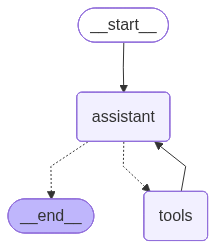

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Input
initial_input = {"messages": HumanMessage(content="Raise 3 to the power of 5")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Raise 3 to the power of 5
================================== Ai Message ==================================
Tool Calls:
  exponent (call_7PR83z5se4gbHcUaFkSs15o5)
 Call ID: call_7PR83z5se4gbHcUaFkSs15o5
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: exponent

243
================================== Ai Message ==================================

3 raised to the power of 5 is 243.


In [5]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Raise 3 to the power of 5', additional_kwargs={}, response_metadata={}, id='633bff36-e844-405e-94f7-48627b396cd5'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7PR83z5se4gbHcUaFkSs15o5', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'exponent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 166, 'total_tokens': 184, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CUwCNDPek9VjkhDeBQ5rum5zBdNTt', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--639a5da3-c8a4-4d84-a72a-f3b0dbc136bd-0', tool_calls=[{'name': 'exponent', 'args': {'a': 3, 'b': 5}, 'id': 'cal

In [6]:
all_states = [s for s in graph.get_state_history(thread)]

In [7]:
len(all_states)

5

In [8]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Raise 3 to the power of 5', additional_kwargs={}, response_metadata={}, id='633bff36-e844-405e-94f7-48627b396cd5')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b279a-3223-659a-8000-0f1635b2f063'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-26T14:39:54.620047+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b279a-3216-6f4e-bfff-dc04aaf3808d'}}, tasks=(PregelTask(id='618ff22b-c203-baf6-50ad-040da90ffb48', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7PR83z5se4gbHcUaFkSs15o5', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'exponent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_token

In [9]:
to_replay = all_states[-2]

In [10]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Raise 3 to the power of 5', additional_kwargs={}, response_metadata={}, id='633bff36-e844-405e-94f7-48627b396cd5')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b279a-3223-659a-8000-0f1635b2f063'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-26T14:39:54.620047+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b279a-3216-6f4e-bfff-dc04aaf3808d'}}, tasks=(PregelTask(id='618ff22b-c203-baf6-50ad-040da90ffb48', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7PR83z5se4gbHcUaFkSs15o5', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'exponent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_token

In [11]:
to_replay.values

{'messages': [HumanMessage(content='Raise 3 to the power of 5', additional_kwargs={}, response_metadata={}, id='633bff36-e844-405e-94f7-48627b396cd5')]}

In [12]:
to_replay.next

('assistant',)

In [13]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b279a-3223-659a-8000-0f1635b2f063'}}

In [14]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Raise 3 to the power of 5
================================== Ai Message ==================================
Tool Calls:
  exponent (call_rKQK4IPi8gnACYMZi53AnIMh)
 Call ID: call_rKQK4IPi8gnACYMZi53AnIMh
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: exponent

243
================================== Ai Message ==================================

3 raised to the power of 5 is 243.


In [15]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Raise 3 to the power of 5', additional_kwargs={}, response_metadata={}, id='633bff36-e844-405e-94f7-48627b396cd5')]

In [16]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b279a-3223-659a-8000-0f1635b2f063'}}

In [17]:
fork_config = graph.update_state(
    to_fork.config,
    {
        "messages": [HumanMessage(content='Raise 3 to the power of 6')],
        "id": to_fork.values["messages"][0].id
    }
)

In [18]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b279a-591a-655e-8001-0e6666ebc3c0'}}

In [19]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Raise 3 to the power of 5', additional_kwargs={}, response_metadata={}, id='633bff36-e844-405e-94f7-48627b396cd5'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7PR83z5se4gbHcUaFkSs15o5', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'exponent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 166, 'total_tokens': 184, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CUwCNDPek9VjkhDeBQ5rum5zBdNTt', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--639a5da3-c8a4-4d84-a72a-f3b0dbc136bd-0', tool_calls=[{'name': 'exponent', 'args': {'a': 3, 'b': 5}, 'id': 'call_7PR83z5se4gbHcUaFkSs15o5', 'typ

In [20]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Raise 3 to the power of 5', additional_kwargs={}, response_metadata={}, id='633bff36-e844-405e-94f7-48627b396cd5'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7PR83z5se4gbHcUaFkSs15o5', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'exponent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 166, 'total_tokens': 184, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CUwCNDPek9VjkhDeBQ5rum5zBdNTt', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--639a5da3-c8a4-4d84-a72a-f3b0dbc136bd-0', tool_calls=[{'name': 'exponent', 'args': {'a': 3, 'b': 5}, 'id': 'cal

In [21]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Raise 3 to the power of 6


In [22]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Raise 3 to the power of 5', additional_kwargs={}, response_metadata={}, id='633bff36-e844-405e-94f7-48627b396cd5'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7PR83z5se4gbHcUaFkSs15o5', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'exponent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 166, 'total_tokens': 184, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CUwCNDPek9VjkhDeBQ5rum5zBdNTt', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--639a5da3-c8a4-4d84-a72a-f3b0dbc136bd-0', tool_calls=[{'name': 'exponent', 'args': {'a': 3, 'b': 5}, 'id': 'cal

In [23]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [24]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [25]:
initial_input = {"messages": HumanMessage(content="Raise 3 to the power of 5")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_JZ3X8RZdwjy3yii05sZaVzDD', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_DhL6NQK4xfIOwpVhUretVCoT', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens': 137, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CUwCSGujhC4MxYcvHa5uff38jA5OG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--00685f26-55ca-495e-8547-e1a5ad9018d5-0', 'example': False, 'tool_c

In [26]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Raise 3 to the power of 5',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'b2344038-067f-421b-89e6-a4317bc21f49',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'e3170b6c-a975-8de8-6626-ce80536a1877',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'tool_calls': [{'id': 'call_JZ3X8RZdwjy3yii05sZaVzDD',
         'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'},
         'type': 'function'},
        {'id': 'call_DhL6NQK4xfIOwpVhUretVCoT',
         'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'},
         'type': 'function'}],
       'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 50,
        'prompt_tokens': 137,
        'total_tokens'

In [27]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a20f6-5137-7077-8327-825bf9d7d17d', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Raise 3 to the power of 5', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'b2344038-067f-421b-89e6-a4317bc21f49', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Raise 3 to the power of 5', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'b2344038-067f-421b-89e6-a4317bc21f49', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_rdiGGGwNiNx29fAZZqofecyT', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_7dnyLG840C9MkliMMnhH8gRV', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens':

In [28]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_E8GLF4NW8V31QR5z0MWJWUoa', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_OpuFdsBJp6jrv1iOoh8igUYH', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens': 137, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CUwCddlGKRtJ0t2jocuKTIHQ57SCo', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--65ad82fa-98e3-41ea-89ca-cc09f9da29d6-0', 'example': False, 'tool_c

In [29]:
initial_input = {"messages": HumanMessage(content="Raise 3 to the power of 5")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_uaq3AHfUmMtL1Edh4fLoKLyu', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_5MITGjzjK21abPGifH9dtVFi', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens': 137, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CUwCiGGgoiAnexTw1v0JgTW8gS31c', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--0908ed3e-9423-44b8-91e0-03112197b036-0', 'example': False, 'tool_c

In [30]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Raise 3 to the power of 5',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': 'd953c183-031e-4040-a659-f4edfc2631d3',
   'example': False}]}

In [31]:
to_fork['values']['messages'][0]['id']

'd953c183-031e-4040-a659-f4edfc2631d3'

In [32]:
to_fork['next']

['assistant']

In [33]:
to_fork['checkpoint_id']

'1f0b279b-0003-6704-8000-a8d44e5c3754'

In [34]:
forked_input = {"messages": HumanMessage(content="Raise 3 to the power of 6",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [35]:
forked_config

{'checkpoint': {'thread_id': '132c9e5e-2d3c-45e1-9dda-aa367e7a4aa4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b279b-3a63-6bf0-8001-b37b70992f1b'},
 'configurable': {'thread_id': '132c9e5e-2d3c-45e1-9dda-aa367e7a4aa4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b279b-3a63-6bf0-8001-b37b70992f1b'},
 'checkpoint_id': '1f0b279b-3a63-6bf0-8001-b37b70992f1b'}

In [36]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Raise 3 to the power of 6',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'd953c183-031e-4040-a659-f4edfc2631d3',
    'example': False},
   {'content': '',
    'additional_kwargs': {'tool_calls': [{'id': 'call_uaq3AHfUmMtL1Edh4fLoKLyu',
       'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'},
       'type': 'function'},
      {'id': 'call_5MITGjzjK21abPGifH9dtVFi',
       'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'},
       'type': 'function'}],
     'refusal': None},
    'response_metadata': {'token_usage': {'completion_tokens': 50,
      'prompt_tokens': 137,
      'total_tokens': 187,
      'completion_tokens_details': {'accepted_prediction_tokens': 0,
       'audio_tokens': 0,
       'reasoning_tokens': 0,
       'rejected_prediction_tokens': 0},
      'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
     'model_name': 'gpt-4o-20

In [37]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': 'd243c618-21a5-4a63-9a52-57dc664d5c90', 'tool_call_id': 'call_5MITGjzjK21abPGifH9dtVFi', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_tQQeVtIiDaUinUSnsulIsx2X', 'function': {'arguments': '{"a": 9, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_J98O3sC8K46ypcWSy4kBwybi', 'function': {'arguments': '{"a": 9, "b": 9}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens': 203, 'total_tokens': 253, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gp